In [2]:
#importing libraries
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [ ]:
#Setting up Base directory and Working directory path
Base_dir='/flickr8k' 
working_dir='/working/'

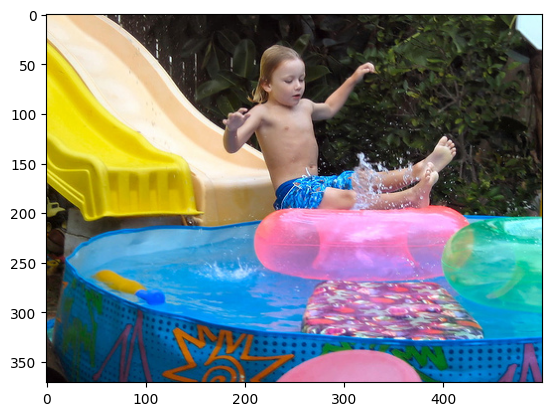

In [4]:
image_name = "1077546505_a4f6c4daa9.jpg"
image_id = image_name.split('.')[0]
img_path = os.path.join(Base_dir, "Images", image_name)
image = Image.open(img_path)
plt.imshow(image)

In [5]:
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
#Image feature Extraction
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
#Storing The Features
features={}
directory=os.path.join(Base_dir,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory +'/'+ img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
#Opening the captions text file
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_file=File.read()

In [9]:
#Dictionary Mapping image IDs to their captions
mapping = {}
for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')
    #Skips lines with fewer than 2 characters (likely blank lines)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

preprocessing(mapping)

In [11]:
#Used to extract all captions from the mapping dictionary into a single list
all_captions = [caption for key in mapping for caption in mapping[key]]


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [13]:
# Get the image IDs
image_ids = list(mapping.keys())

# Split into train and test sets (90% train, 10% test)
train, test = train_test_split(image_ids, test_size=0.1, random_state=42)

In [14]:
#Data Generation
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [] , [] ,[] 
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear()  # Clears the content of X1
                X2.clear()  # Clears the content of X2
                y.clear()   # Clears the content of y
                n = 0

In [24]:
# image feature layers
#4096 is the output of second last layer of the vgg16
inputs1=Input(shape=(4096,),name="image")
a=Dropout(0.3)(inputs1)
X=Dense(256,activation='relu')(a)

# sequence feature layers
inputs2=Input(shape=(max_length,),name="text")
c=Embedding(vocab_size,256)(inputs2)
d=Dropout(0.3)(c)
Y=LSTM(256)(d)



decoder1=add([X , Y])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 4096)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 35, 256)        │      2,172,160 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 4096)           │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 35, 256)        │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │      1,048,832 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 256)            │        525,312 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256)            │              0 │ dense_9[0][0],         │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         65,792 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 8485)           │      2,180,645 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

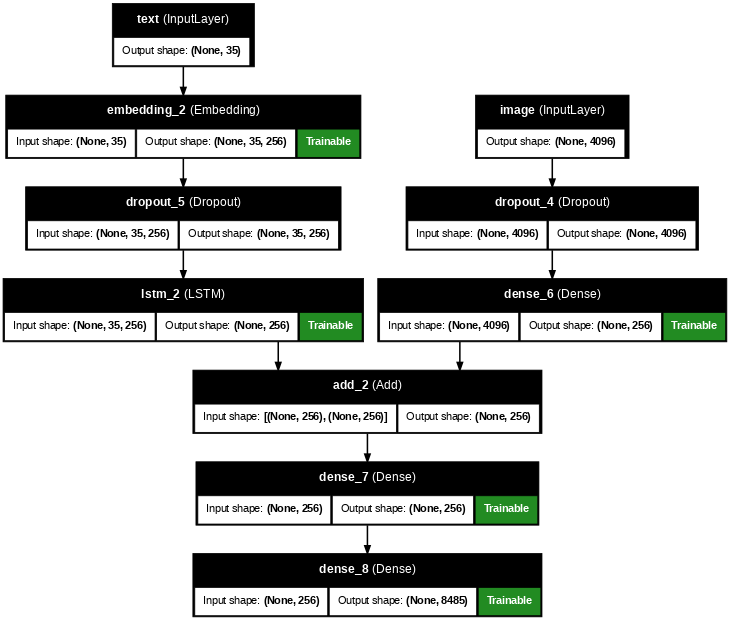

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

In [25]:
#Trainging the model
epochs=12
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 229ms/step - loss: 5.7606
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 4.0153
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 3.5297
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - loss: 3.0310
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.8735
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.6655
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - loss: 2.5878
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - loss: 2.5176
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step - loss: 2.4523
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.3975


In [44]:
#Generate Captions for the Image
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text


In [45]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

startseq dog is playing in the yard endseq


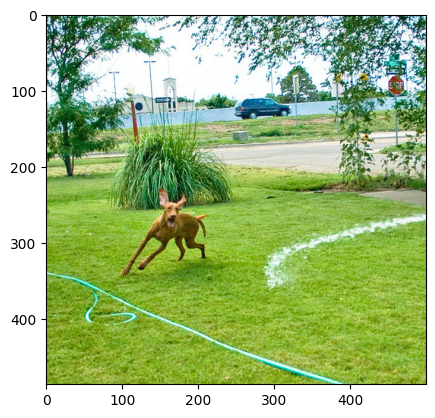

In [46]:
generate_caption("1019077836_6fc9b15408.jpg")


In [32]:
#BLEU Score
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = [] , []

for key in tqdm(test):

    captions = mapping[key] 
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

    # calcuate BLEU score
#Unigram
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#Bigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.568229
BLEU-2: 0.343302


In [33]:
#Saving the model
model.save('model.h5')


In [34]:
pickle.dump(tokenizer , open('tokenizer.pkl','wb'))

In [35]:
#Text to speech
!pip install gtts

In [36]:
# listen to predicted text
from gtts import gTTS
from IPython.display import Audio, display

In [47]:
caption_text = ' '.join(y_pred)

# Now, replace 'startseq' and 'endseq' and strip the caption
caption_text = caption_text.replace('startseq', '').replace('endseq', '').strip()
# Display the predicted caption
print("Predicted Caption:", caption_text)

# Step 1: Generate the audio for the caption using gTTS
tts = gTTS(caption_text, lang='en')
audio_path = "predicted_caption.mp3"
tts.save(audio_path)

# Step 2: Display the audio player before the image
print("Playing the predicted caption audio:")
display(Audio(audio_path, autoplay=True))

Predicted Caption: two dogs are swimming in the water
Playing the predicted caption audio:
